# Data Preprocessing

This notebook describes how the signal and background raw data are preprocessed. The signal is a Higgs boson simulated sample, the background a ttbar simulated sample. All raw data have already been filtered using the [Hbb+jet analysis](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.105.092003) event selection.

In [1]:
import sys
sys.path.append('../')
import pandas
import matplotlib.pyplot as plt
from hbbclass.preprocessing import root_to_pandas, train_test_sample
from hbbclass.plotting import compare_feature
# Random seed for reproducible results
seed = 42

## Data Description and Extraction

The signal and background samples are characterised by events containing a "Higgs candidate jet", an object that can be produced by the decay of a Higgs boson, a top quark, or other activity in the event. Higgs boson jets (signal) selected by the analysis are characterised by a "2-prong" decay signature. Conversely, jets originated by top-quark decays (background) are typically "3-prong".

The goal of this study is to understand if it is possible to classify signal and background jets based on their "n-prongness" by studying the energy correlations between the energy deposits of their decay products. This information is provided by the jet substructure variables `C2`, `D2`, `tau21` and `tau32`.

The table below lists the variables relevant to this study:

| Variable      | Description                                                     |
|---------------|-----------------------------------------------------------------|
| `Hcand_m`     | Higgs candidate jet mass                                        |
| `Hcand_C2`    | Higgs candidate jet C2 energy correlation substructure variable |
| `Hcand_D2`    | Higgs candidate jet D2 energy correlation substructure variable |
| `Hcand_tau21` | Higgs candidate jet tau21 subjettiness substructure variable    |
| `Hcand_tau32` | Higgs candidate jet tau32 subjettiness substructure variable    |
| `w`           | Total event weight                                              |

`C2`, `D2` and `tau21` are closer to `0` when the Higgs candidate jet is consistent with a 2-prong substructure. `tau32` is closer to `0` when the Higgs candidate jet is consistent with a 3-prong substructure.

In the following, the raw data is loaded and converted from the ROOT TTree format to pandas dataframes.

In [2]:
# Define variable names
columns = [
    'Hcand_m',
    'Hcand_C2',
    'Hcand_D2',
    'Hcand_tau21',
    'Hcand_tau32',
    'w'
]
# Load signal sample
df_sig = root_to_pandas('../data/raw/Higgs_srl.root', columns)
# Load backgound sample
df_bkg = root_to_pandas('../data/raw/ttbar_PowPy8_srl.root', columns)

## Data Cleaning

In this section we explore the raw datasets and remove any undesirable events. In particular, we check for events with negative weights and `NaN` values.

In [3]:
# Describe the signal sample features
df_sig.describe()

,Hcand_m,Hcand_C2,Hcand_D2,Hcand_tau21,Hcand_tau32,w
count,234045.000000,234044.000000,234044.000000,234044.000000,234027.000000,234045.000000
mean,156.446106,0.169186,1.248909,0.350663,0.585659,0.001956
std,60.356606,0.085888,0.492251,0.153666,0.162839,0.006990
min,60.044930,0.000000,0.000000,0.000000,0.000000,-1.649303
25%,118.824966,0.102323,0.925815,0.228188,0.480180,0.000250
50%,131.606003,0.146906,1.196702,0.339196,0.612713,0.000712
75%,183.317062,0.229458,1.476404,0.466693,0.712195,0.001274
max,776.466980,0.510581,14.967789,0.875948,0.929519,0.131582


In [4]:
# Describe the background sample features
df_bkg.describe()

,Hcand_m,Hcand_C2,Hcand_D2,Hcand_tau21,Hcand_tau32,w
count,73703.000000,73703.000000,73703.000000,73703.000000,73698.000000,73703.000000
mean,172.374039,0.204673,1.312798,0.402422,0.524074,0.204273
std,58.165047,0.082981,0.439810,0.152748,0.163877,0.129802
min,60.003716,0.000000,0.000000,0.000000,0.000000,-0.545178
25%,139.200905,0.139841,1.062311,0.291149,0.403633,0.140191
50%,167.602570,0.206803,1.279620,0.414478,0.532233,0.165941
75%,192.772217,0.264247,1.522778,0.517615,0.651313,0.320061
max,1177.437256,0.483084,6.685217,0.859372,0.921992,0.801747


Let's check for the presence of events with negative weights and `NaN` values:

In [5]:
# Total number of signal and background events
sig_events = df_sig.shape[0]
bkg_events = df_bkg.shape[0]
# Events with negative weights
sig_neg_w = df_sig['w'].loc[df_sig['w'] < 0].count()
bkg_neg_w = df_bkg['w'].loc[df_bkg['w'] < 0].count()
perc_sig_neg_w = round(float(sig_neg_w*100)/sig_events, 2)
perc_bkg_neg_w = round(float(bkg_neg_w*100)/bkg_events, 2)
# Number of NaN values
sig_nan = df_sig.isnull().sum().sum()
bkg_nan = df_bkg.isnull().sum().sum()

print(f'Signal sample has {sig_neg_w} events with negative weights ({perc_sig_neg_w}%).')
print(f'Backgound sample has {bkg_neg_w} events with negative weights ({perc_bkg_neg_w}%).')
print(f'Signal sample has a total of {sig_nan} NaN values.')
print(f'Background sample has a total {bkg_nan} NaN values.')
print('\nDistribution of NaN values across signal sample features:')
print(df_sig.isnull().sum())
print('\nDistribution of NaN values across background sample features:')
print(df_bkg.isnull().sum())

Signal sample has 6451 events with negative weights (2.76%).
Backgound sample has 1472 events with negative weights (2.0%).
Signal sample has a total of 21 NaN values.
Background sample has a total 5 NaN values.

Distribution of NaN values across signal sample features:
Hcand_m         0
Hcand_C2        1
Hcand_D2        1
Hcand_tau21     1
Hcand_tau32    18
w               0
dtype: int64

Distribution of NaN values across background sample features:
Hcand_m        0
Hcand_C2       0
Hcand_D2       0
Hcand_tau21    0
Hcand_tau32    5
w              0
dtype: int64


Since the number of events with negative weights or NaN features is very small, it is possible to safely drop the corresponding rows from the datasets.

In [6]:
# Drop events with negative values
df_sig = df_sig[df_sig['w'] >= 0]
df_bkg = df_bkg[df_bkg['w'] >= 0]
# Drop events with NaN feature values
df_sig.dropna(axis=0, inplace=True)
df_bkg.dropna(axis=0, inplace=True)


## Train and Test Datasets

First we add the `is_signal` prediction label. It is a binary flag taking value `1` for the events in the signal sample and `0` for the events in the background sample.

Then, we split the signal and background samples into train and test datasets. Since we are dealing with weighted events, we also sample them with replacement according to said weight. This is taken care by the `train_test_sample` function.

We sample 70,000 events from the signal and background samples and we split them 70-30% into train and test datasets.

Finally, we concatenate the signal and background train datasets and the signal and background test datasets together and we save them as `.csv` files for later use.

In [7]:
# Add prediction label
if 'is_signal' not in df_sig:
    df_sig.insert(0, 'is_signal', [1]*len(df_sig.index), True)
if 'is_signal' not in df_bkg:
    df_bkg.insert(0, 'is_signal', [0]*len(df_bkg.index), True)
# split samples into train and test datasets
n_samples = 70000
frac_train = 0.7
df_sig_train, df_sig_test = train_test_sample(df_sig, n_samples, frac_train, 'w', random_state=seed)
df_bkg_train, df_bkg_test = train_test_sample(df_bkg, n_samples, frac_train, 'w', random_state=seed)
# Concatenate dataframes
df_train = pandas.concat([df_sig_train, df_bkg_train])
df_test = pandas.concat([df_sig_test, df_bkg_test])
# Shuffle dataframes
df_train = df_train.sample(frac=1, random_state=seed)
df_test = df_test.sample(frac=1, random_state=seed)
# Reset indexes
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
# Some sanity checks
assert df_train.shape[0] == int(2*n_samples*frac_train)
assert df_test.shape[0] == int(2*n_samples*(1-frac_train))
# Save preprocessed samples to csv files
df_train.to_csv('../data/processed/train.csv')
df_test.to_csv('../data/processed/test.csv')

## Visualisation

Finally, let's visualise the signal and background features of the train dataset.

The Higgs candidate jet substructure variables `C2`, `D2`, `tau21` and `tau32` will be used to train Higgs classifiers.

Since the Higgs candidate jet mass is used by the analysis to separate the signal and background events using maximum likelihood methods, it will not be used as input to the classifiers.  

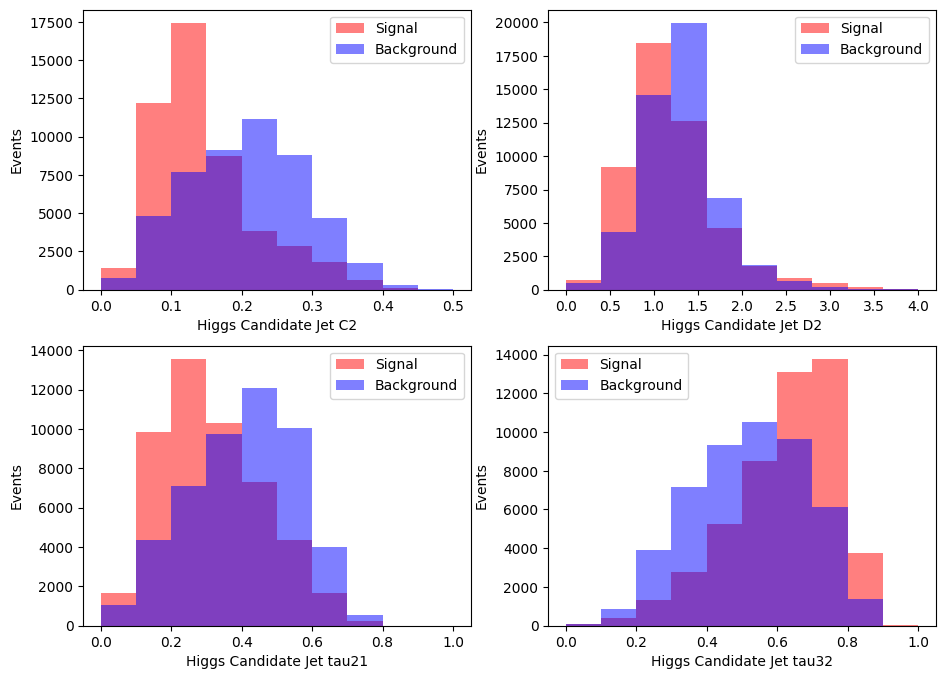

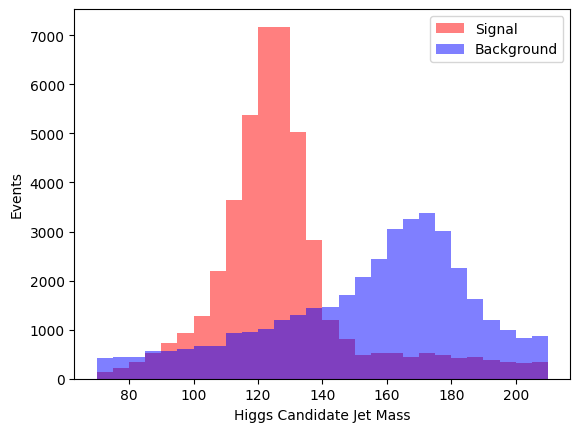

In [8]:
# Plot Higgs candidate jet substructure variables
fig, axs = plt.subplots(2, 2, figsize=(11,8))
compare_feature(df_train, 'Hcand_C2', limits=(0, 0.5), x_label='Higgs Candidate Jet C2', y_label='Events', ax=axs[0, 0])
compare_feature(df_train, 'Hcand_D2', limits=(0, 4), x_label='Higgs Candidate Jet D2', y_label='Events', ax=axs[0, 1])
compare_feature(df_train, 'Hcand_tau21', limits=(0, 1), x_label='Higgs Candidate Jet tau21', y_label='Events', ax=axs[1, 0])
compare_feature(df_train, 'Hcand_tau32', limits=(0, 1), x_label='Higgs Candidate Jet tau32',  y_label='Events', ax=axs[1, 1])
# Plot Higgs candidate jet mass
compare_feature(df_train, 'Hcand_m', limits=(70, 210), bins=28, x_label='Higgs Candidate Jet Mass', y_label='Events')